# LDA Topic Modeling

In this notebook we will use LDA models optimized for coherence to review the topics present in the rmt corpus.

We will train a [latent dirichlet allocation model (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
) to discover topics in the data. LDA is a type of natural language processing model that gets topics from the corpus. You must specify the number of topics you want to extract, we iterate over different quantities of topics for each corpus and, later, use coherence analysis to select the best number of topic in the range. 
We will use `gensim`'s built in functionality to train the model. LDA models require a given number of topics to be sepcified. We will train models for different numbers of topics. Later on we will select between these models using topic coherence as our crtieria. A lot of the code in this section was pulled from the [topic_coherence_model_selection notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_coherence_model_selection.ipynb) in the gensim repo. 

In [22]:
import bear_necessities as bn
import os
import time
import re 
import numpy as np
import pandas as pd
import modeling_tools as mt
import warnings
import lda_analysis as ld
import visuals as vs
from importlib import reload
from gensim.corpora import Dictionary
warnings.filterwarnings('ignore')

import random
random.seed(3)

## Setting Experimental Parameters 

Just as we did in the cleaning steps, there are certain things we will want to vary to retrieve the optimal results. The version of cleaned data is one of them, here are all the experimental parameters we will vary: 

* Data configuration: of our cleaning steps, two (A1 & E1) are suited for LDA analysis. We will use both. 
* Review length: very short reviews are less likely to convey valuable information, in the following cell block we will check review length distribution to set the values for this parameter. 
* Number of topics: LDA requires that we submit a number of topics before hand, we do not know how many topics can be found in each corpus so we will iterate through an array of these and select the best later.  
* Passes: number of passes to make over the corpus (akin to epochs or iterations)
* N-below: exclude words that occur fewer than this number of times 
* N-above: exclude words that occure in over this percentage of reviews 

**Selecting a Target**

Besides these parameters there is one other item to decide which is the target of our analysis. We have generated two general sets of indices, reviews in certain ranges, and reviews with certain characteristic lables. Either can be used in LDA (unsupervised) or supervised learning contexts. 

Our goal is to identify the profiles of bad teaching and use good reviews to contrast and contextualize these. We will assume that longer reviews contain more information, thus we will vary the input to our LDA models based on review length. Below we examine the statistics around review length and decide exactly what we want to target. 

In [23]:
# import the data if need be
data = bn.decompress_pickle(os.getcwd() + '/data/review_stats.pbz2')

In [24]:
# import the labels indices 
label_dict = bn.decompress_pickle(os.getcwd()+'/data/labeled_indices.pbz2')   
# import the range indices 
range_indices = bn.loosen(os.getcwd() + '/data/by_rating_range.pickle')
# create a list of each range 
ranges = list(np.sort(list(range_indices.keys())))

*Display a graph and tables with summary stats for the distribution of* `Review_Length` *across corpus*

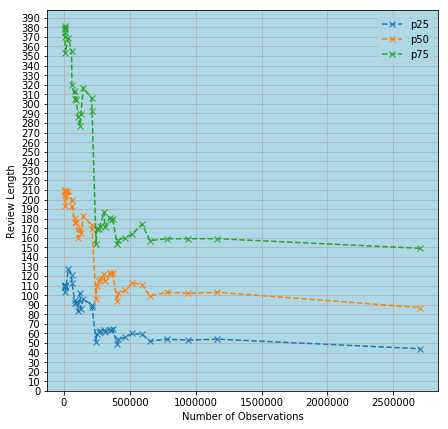

,"[0, 35)"
count,"359,387"
mean,142
std,112
min,1
25%,64
50%,122
75%,179
max,"1,977"
,"[35, 60)"
count,"309,850"


In [26]:
vs = reload(vs)

tables = []
for rng in ranges: 
    # setup the summary stat table, format into thousands and append to the list of descriptive tables 
    t = pd.DataFrame(data.loc[range_indices[rng],'Review_Length'].describe().astype(int)).rename(columns={'Review_Length':rng})
    t[rng] = t[rng].apply(lambda x: "{:,}".format(x))
    tables.append(t)

for k in label_dict: 
    for v in label_dict[k]: 
        if v != 5: 
            t = pd.DataFrame(data.loc[label_dict[k][v],'Review_Length'].describe().astype(int)).rename(columns={'Review_Length':k+': '+str(int(v))})
            t[k+': '+str(int(v))] = t[k+': '+str(int(v))].apply(lambda x: "{:,}".format(x))
            tables.append(t)

vs.chart_review_lengths(tables)
vs.display_side_by_side(tables)

* Reviewing the distribution of review lengths above there is a clear correlation between corpus size and review length which is curious since the corpus are determined based on characteristic values and not statistical parameters. 
* Most of the corpus with fewer (but longer) reviews are those with low ratings on teacher characteristics [this sentence was 105 characters to put things in perspective].
* This finding suggest that high ratings are a sort of "default" while lower ratings will tend to be more informative (keep in mind we do not say anything about whether these describe teachers more accurately as there is no way to verify that).  

*Setting the Review Length Parameter*

Restricting the review length for the corpus defined by ranges of ratings will not exclude a significant ammount of reviews that have low likert scale ratings. Thus, we will target ranges using LDA analysis. We will define differing sets of review length parameters for each corpus based on the summary statistics above. 

In [ ]:
lda_parameters = hardcoded_lda_parameters(ranges, range_indices)

### Model Selection by Topic Coherence 

We will use topic coherence for model selection. Topic coherence measures summarize the "interpretability" of the topics resulting from a particular training model. These measures are relative, in other words they are used to compare models to one another rather than evaluate the "absolute" coherence of topics. 

A good explanation of how these measures work can be found [here](https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/) but basically, these measures look at the similarity of words within topics, the similarity between topis, and then combines these factors into an aggregate measure. The intuition being that by increasing consistency within topics and minimizing redundancy across topics we yield more human-interpretable results. 

There are several different coherence measures, we will be using the "c_v" measure which was found to out-perform other measures in the paper ["Exploring the Space of Topic Coherence Measures"](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). If time (and computing power) permits, we will also use the "c_w2v" measure which has been [shown](https://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) to reduce the noise in the estimation of the "c_v" by using Word2Vec embeddings to implicitly factorize the distance matrices required to calculate the measure. 

In [28]:
ld = reload(ld)

# we craete a dataset where we can store the experimental results 
experimental_setup = pd.DataFrame()

# list the data configurations we want to try 
data_configurations = ['A1','E1']

for config in data_configurations: 

    # load the cleaned text data
    text, stem_map, lemma_map, phrase_frequencies = bn.decompress_pickle(os.getcwd()+'/data/cleaned_data/cleaned_docs_'+config+'.pbz2')
    
    # for each parameter setting
    for setting in lda_parameters:
        
        # define the directory where you want to save the models
        model_directory = os.getcwd()+'/models/'+setting+'_'+config
        
        # now for each range
        for rng in ranges: 
            print(rng,setting,config)
            # get the rows in the data that you need 
            indices = data.loc[range_indices[rng],'Review_Length']

            # filter the trainin corpus by review length and save the length 
            docs = [text[idx] for idx in indices[indices>lda_parameters[setting][rng]['review_length']].index]

            # save additional info to for the experimental record 
            lda_parameters[setting][rng]['filtered_length'] = len(docs)
            lda_parameters[setting][rng]['data_configuration'] = config
            lda_parameters[setting][rng]['setting'] = setting

            # train the lda models
            trained_models, corpus, dictionary, lda_parameters[setting][rng]['duration'] = ld.run_lda(docs, 
                                                                         lda_parameters[setting][rng])
            # name & save the lda models
            ld.save_models(trained_models, 
                           model_directory,
                           setting+'_'+config+'_'+rng)
        
        # we save the outcomes of the data to the exprerimental setup dataset 
        experimental_setup = experimental_setup.append(pd.DataFrame(lda_parameters[setting]).transpose())

Available Cores: 7
[0, 35) LDA1 A1
Training LDA(k=10)
Training LDA(k=25)
Training LDA(k=40)
Training LDA(k=55)
Training LDA(k=70)
Training LDA(k=85)
Training LDA(k=100)
Training all the models on the corpus took 5508.4329998493195
[35, 60) LDA1 A1
Training LDA(k=10)
Training LDA(k=25)
Training LDA(k=40)
Training LDA(k=55)
Training LDA(k=70)
Training LDA(k=85)
Training LDA(k=100)
Training all the models on the corpus took 4733.5920078754425
[60, 65) LDA1 A1
Training LDA(k=10)
Training LDA(k=25)
Training LDA(k=40)
Training LDA(k=55)
Training LDA(k=70)
Training LDA(k=85)
Training LDA(k=100)
Training all the models on the corpus took 3079.8730943202972
[65, 75) LDA1 A1
Training LDA(k=10)
Training LDA(k=25)
Training LDA(k=40)
Training LDA(k=55)
Training LDA(k=70)
Training LDA(k=85)
Training LDA(k=100)
Training all the models on the corpus took 3889.679929256439
[75, 85) LDA1 A1
Training LDA(k=10)
Training LDA(k=25)
Training LDA(k=40)
Training LDA(k=55)
Training LDA(k=70)
Training LDA(k=85)


In [29]:
# pre-load the datasets so we don't have to load them for each loop. 
materials = {}
materials['A1'] = bn.decompress_pickle(os.getcwd()+'/data/cleaned_data/cleaned_docs_A1.pbz2') 
materials['E1'] = bn.decompress_pickle(os.getcwd()+'/data/cleaned_data/cleaned_docs_E1.pbz2') 
# we will store each topic's coherence score in this dictionary 
coherence_guide = {} 
for idx, row in experimental_setup.iterrows():

    model_directory = os.getcwd()+'/models/'+row['setting']+'_'+row['data_configuration']
    setting = row['setting']
    config = row['data_configuration']
    rng = idx
    indices = data.loc[range_indices[rng],'Review_Length']
    text,stem_map,lemma_map,phrase_frequencies=materials[config]
    
    # filter the training corpus by review length and save the length 
    docs = [text[idx] for idx in indices[indices>lda_parameters[setting][rng]['review_length']].index]
    
    trained_models = ld.load_models(model_directory,setting+'_'+config+'_'+rng,list(range(10,101,15)))

    corpus, dictionary, literal_dictionary, id2word, word2id = mt.set_dictionary(docs,
                                                                             lda_parameters[setting][rng]['nbelow'],
                                                                             lda_parameters[setting][rng]['nabove'])
    # get the ranked coherence models and the coherence
    ranked, coherences = ld.determine_coherence(trained_models, dictionary, docs)

    # store the ranked models in the experimental setup dataset 
    row['coherence_scores'] = ranked
    
    # store the full coherence scores per topic in a separate dictionary object
    if idx not in coherence_guide: coherence_guide[idx]={} 
    if config not in coherence_guide[idx]: coherence_guide[idx][config]={}
    if setting not in coherence_guide[idx][config]: coherence_guide[idx][config][setting]={}

    coherence_guide[idx][config][setting] = [(k,coherences[k]) for k in coherences]

Ranked by average 'c_v' coherence:

num_topics=25:	0.5049
num_topics=10:	0.4769
num_topics=40:	0.4630
num_topics=55:	0.4539
num_topics=85:	0.4361
num_topics=70:	0.4321
num_topics=100:	0.4308

Best: 25
Ranked by average 'c_v' coherence:

num_topics=25:	0.4682
num_topics=40:	0.4619
num_topics=10:	0.4618
num_topics=55:	0.4363
num_topics=70:	0.4250
num_topics=85:	0.4229
num_topics=100:	0.4194

Best: 25
Ranked by average 'c_v' coherence:

num_topics=25:	0.4513
num_topics=10:	0.4436
num_topics=40:	0.4296
num_topics=55:	0.4212
num_topics=70:	0.4110
num_topics=85:	0.4053
num_topics=100:	0.4041

Best: 25
Ranked by average 'c_v' coherence:

num_topics=25:	0.4683
num_topics=10:	0.4490
num_topics=40:	0.4453
num_topics=70:	0.4367
num_topics=55:	0.4291
num_topics=85:	0.4186
num_topics=100:	0.4129

Best: 25
Ranked by average 'c_v' coherence:

num_topics=25:	0.4532
num_topics=10:	0.4452
num_topics=40:	0.4286
num_topics=70:	0.4255
num_topics=55:	0.4168
num_topics=100:	0.4114
num_topics=85:	0.4102

Best

In [30]:
bn.compressed_pickle(os.getcwd()+'/results/lda_coherence_per_topic_dict', coherence_guide)

In [31]:
experimental_setup.sort_index().to_csv(os.getcwd()+'/documents/lda_experimental_register.csv')
experimental_setup

,corpus_length,data_configuration,duration,filtered_length,nabove,nbelow,ntrange,passes,review_length,setting
"[0, 35)",359387,A1,5508.43,211224,0.5,30,"[10, 25, 40, 55, 70, 85, 100]",32,100,LDA1
"[35, 60)",309850,A1,4733.59,174930,0.5,30,"[10, 25, 40, 55, 70, 85, 100]",32,100,LDA1
"[60, 65)",244504,A1,3079.87,116906,0.5,30,"[10, 25, 40, 55, 70, 85, 100]",32,100,LDA1
"[65, 75)",248963,A1,3889.68,135593,0.5,30,"[10, 25, 40, 55, 70, 85, 100]",32,100,LDA1
"[75, 85)",404741,A1,4690.57,190701,0.5,30,"[10, 25, 40, 55, 70, 85, 100]",32,100,LDA1
"[85, 95)",593581,A1,7794.23,325955,0.5,30,"[10, 25, 40, 55, 70, 85, 100]",32,100,LDA1
"[95, 101)",2702952,A1,12136,428507,0.5,30,"[10, 25, 40, 55, 70, 85, 100]",32,175,LDA1
"[0, 35)",359387,A1,6709.46,136193,0.5,20,"[10, 25, 40, 55, 70, 85, 100]",50,150,LDA2
"[35, 60)",309850,A1,5501.17,108447,0.5,20,"[10, 25, 40, 55, 70, 85, 100]",50,150,LDA2
"[60, 65)",244504,A1,3483.42,64430,0.5,20,"[10, 25, 40, 55, 70, 85, 100]",50,150,LDA2


## Reviewing Topics

* We use the pyLDAvis module to generate easy to use visualizations of the topics generated in the LDA model. These are in the graphs folder. 
* We also save key words for each of the topics for each of the models in the `topic_words*` files. 
* Finally, we save the topic distributions for each document (how much of each topic covers a given doc) in the `topic_assignments*` files. 

We do so for the "most coherent" model in each trial

In [32]:
# load the experimental results if need be
experimental_setup = pd.read_csv(os.getcwd()+'/documents/lda_experimental_register.csv', index_col =0)

In [ ]:
# tres = experimental_setup.loc[(experimental_setup['data_configuration']=='A1')&
#                               (experimental_setup['setting']=='LDA1')&
#                               (experimental_setup.index=='[0, 35)')]

In [ ]:
ld=reload(ld)
import random

# specify the number of words  you want to display when describing each topic 
num_words = 15

# same as above, we want to loop through the experiment and create the graphs as needed 
materials = {}
materials['A1'] = bn.decompress_pickle(os.getcwd()+'/data/cleaned_data/cleaned_docs_A1.pbz2') 
materials['E1'] = bn.decompress_pickle(os.getcwd()+'/data/cleaned_data/cleaned_docs_E1.pbz2') 
full_text = bn.decompress_pickle(os.getcwd()+'/data/full_review_text.pbz2')

for idx, row in experimental_setup.iterrows():
    random.seed(3)
    # get the information necessary to load the materials 
    model_directory = os.getcwd()+'/models/'+row['setting']+'_'+row['data_configuration']
    setting = row['setting']
    config = row['data_configuration']
    rng = idx
    # pull the column of review length
    indices = data.loc[range_indices[rng],'Review_Length']
    text,stem_map,lemma_map,phrase_frequencies=materials[config]
    # keep the indices of the rows with review length > than the minimum length
    filtered_index = indices[indices>lda_parameters[setting][rng]['review_length']].index
    
    # filter the training corpus by review length and save the length 
    docs = [text[idx] for idx in filtered_index]
    # get original reviews for the same documents 
    fulldocs = [full_text[idx] for idx in filtered_index]
    
    # load the models 
    trained_models = ld.load_models(model_directory,setting+'_'+config+'_'+rng,list(range(10,101,15)))

    # get the dictionary 
    corpus, dictionary, literal_dictionary, id2word, word2id = mt.set_dictionary(docs,
                                                                             lda_parameters[setting][rng]['nbelow'],
                                                                             lda_parameters[setting][rng]['nabove'])

    # extract the coherence score data
    coherence_scores=list(zip(re.findall('[0-9]+\.*[0-9]*', row['coherence_scores'])[::2],
                              re.findall('[0-9]+\.*[0-9]*', row['coherence_scores'])[1::2]))

    # get the topic num with the top coherence score 
    best_topic_num = int(coherence_scores[0][0])

    # get the most coherent model 
    model = trained_models[best_topic_num]

    # specify paths to save the results  
    lda_viz_path = os.getcwd()+'/graphs/LDA Graphs/Viz_'+rng+'_'+str(best_topic_num)+'_'+setting+'_'+config+'.html'
    topic_des_path = os.getcwd()+'/results/LDA Descriptions/Des_'+rng+'_'+str(best_topic_num)+'_'+setting+'_'+config+'.csv'
    topic_vec_path = os.getcwd()+'/results/LDA Distributions/Vec_'+rng+'_'+str(best_topic_num)+'_'+setting+'_'+config # no extension because we will compress
    
    # Create and save the topic pyLDAvis HTML topic visualization 
    vs.save_topic_visualization(model, docs, dictionary, lda_viz_path)
    
    # Save the top words for each topic and their coefficients 
    ld.write_lda_descriptions(topic_des_path, model, num_words)

    # Get main topic in each document
    sentence_topics_df = ld.get_sentence_topics(model, corpus, fulldocs, path=topic_vec_path)